In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

# Não está bom

In [68]:
start_date = '2017-01-01'

In [72]:
# read and load the csv files
vol_bitfinex_by_supply_btc = pd.read_csv("light_data/vol_bitfinex_by_supply_btc.csv")
total_out_BTC_USD = pd.read_csv("light_data/total_out_BTC_USD.csv")
total_out_BTC_USD = total_out_BTC_USD[total_out_BTC_USD["Date"] >= start_date]

vol_bitfinex_by_supply_btc.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
vol_bitfinex_by_supply_btc.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
vol_bitfinex_by_supply_btc = vol_bitfinex_by_supply_btc[vol_bitfinex_by_supply_btc["Date"] >= start_date]

<Axes: xlabel='Date'>

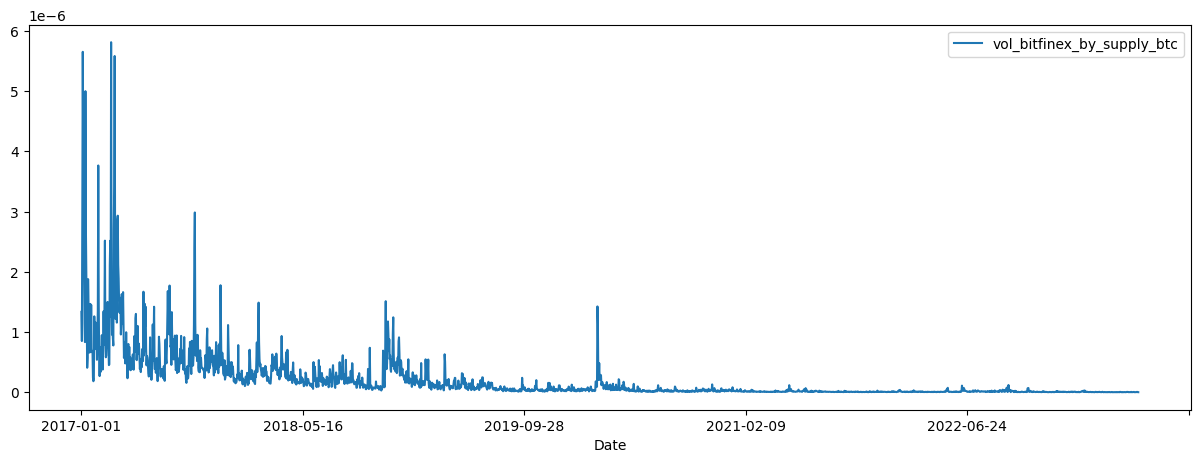

In [73]:
vol_bitfinex_by_supply_btc.plot(x="Date", y="vol_bitfinex_by_supply_btc", figsize=(15, 5))


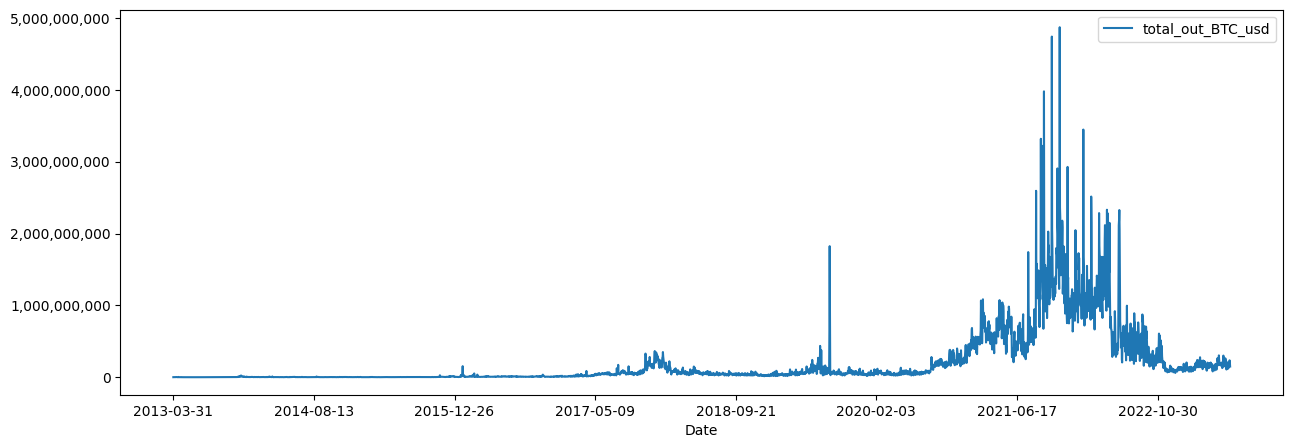

In [58]:
total_out_BTC_USD.plot(x="Date", y="total_out_BTC_usd", figsize=(15, 5))
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()


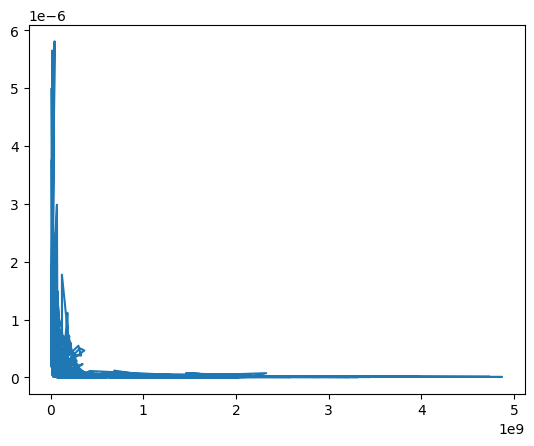

In [74]:
plt.plot(total_out_BTC_USD["total_out_BTC_usd"], vol_bitfinex_by_supply_btc["vol_bitfinex_by_supply_btc"])


# Verify stationarity

In [75]:
def test_stationarity(series):
    result = adfuller(series)
    p_value = result[1]
    
    if p_value <= 0.05:
        print("A série é estacionária.")
    else:
        print("A série não é estacionária.")

test_stationarity(total_out_BTC_USD["total_out_BTC_usd"])
test_stationarity(vol_bitfinex_by_supply_btc["vol_bitfinex_by_supply_btc"])

A série não é estacionária.
A série é estacionária.


# Diff for non stationary series

In [76]:
total_out_BTC_USD["total_out_BTC_usd_diff"] = total_out_BTC_USD["total_out_BTC_usd"].diff()
total_out_BTC_USD = total_out_BTC_USD.dropna() 
test_stationarity(total_out_BTC_USD["total_out_BTC_usd_diff"]) 

A série é estacionária.


In [77]:
# Remove the first row of the dataframe to garantee the same size of the two dataframes
vol_bitfinex_by_supply_btc.iloc[0] = np.nan
vol_bitfinex_by_supply_btc = vol_bitfinex_by_supply_btc.dropna()
vol_bitfinex_by_supply_btc

,Date,vol_bitfinex_by_supply_btc
1373,2017-01-02,8.508254e-07
1374,2017-01-03,2.954239e-06
1375,2017-01-04,5.653340e-06
1376,2017-01-05,3.983552e-06
1377,2017-01-06,2.783701e-06
...,...,...
3754,2023-07-11,2.776199e-09
3755,2023-07-12,6.164820e-09
3756,2023-07-13,5.070062e-09
3757,2023-07-14,1.085426e-09


In [78]:
total_out_BTC_USD

,Date,total_out_BTC_usd,total_out_BTC_usd_diff
1373,2017-01-02,1.021862e+07,3.154958e+06
1374,2017-01-03,1.346419e+07,3.245569e+06
1375,2017-01-04,1.628879e+07,2.824595e+06
1376,2017-01-05,1.920555e+07,2.916766e+06
1377,2017-01-06,1.747914e+07,-1.726412e+06
...,...,...,...
3754,2023-07-11,1.835730e+08,1.943238e+06
3755,2023-07-12,1.975522e+08,1.397913e+07
3756,2023-07-13,2.349778e+08,3.742569e+07
3757,2023-07-14,2.077230e+08,-2.725484e+07


In [79]:
df_var = pd.concat([total_out_BTC_USD["total_out_BTC_usd_diff"], vol_bitfinex_by_supply_btc["vol_bitfinex_by_supply_btc"]],axis=1)
df_var = df_var.set_index(vol_bitfinex_by_supply_btc["Date"]) 
df_var

,total_out_BTC_usd_diff,vol_bitfinex_by_supply_btc
Date,,
2017-01-02,3.154958e+06,8.508254e-07
2017-01-03,3.245569e+06,2.954239e-06
2017-01-04,2.824595e+06,5.653340e-06
2017-01-05,2.916766e+06,3.983552e-06
2017-01-06,-1.726412e+06,2.783701e-06
...,...,...
2023-07-11,1.943238e+06,2.776199e-09
2023-07-12,1.397913e+07,6.164820e-09
2023-07-13,3.742569e+07,5.070062e-09


# Adjust VAR Model

In [80]:
model = VAR(df_var)
result = model.fit(2)  # 2 é o atraso (número de lags)

print(result.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 10, Nov, 2023
Time:                     15:42:49
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    8.17701
Nobs:                     2384.00    HQIC:                   8.16160
Log likelihood:          -16473.6    FPE:                    3473.02
AIC:                      8.15278    Det(Omega_mle):         3458.50
--------------------------------------------------------------------
Results for equation total_out_BTC_usd_diff
                                       coefficient             std. error           t-stat            prob
----------------------------------------------------------------------------------------------------------
const                               -208194.787419         4971352.921659           -0.042           0.967
L1.total_out_BTC_usd_diff                -0.32

/home/moises/.pyenv/versions/3.11.3/envs/research_btc/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [81]:
# Fazendo previsões para 2 períodos à frente
forecast = result.forecast(df_var.values, steps=2)

# Exibindo as previsões
print("Previsões:")
print(forecast)

Previsões:
[[2.61679455e+07 3.44730800e-08]
 [7.44053749e+06 5.64001690e-08]]


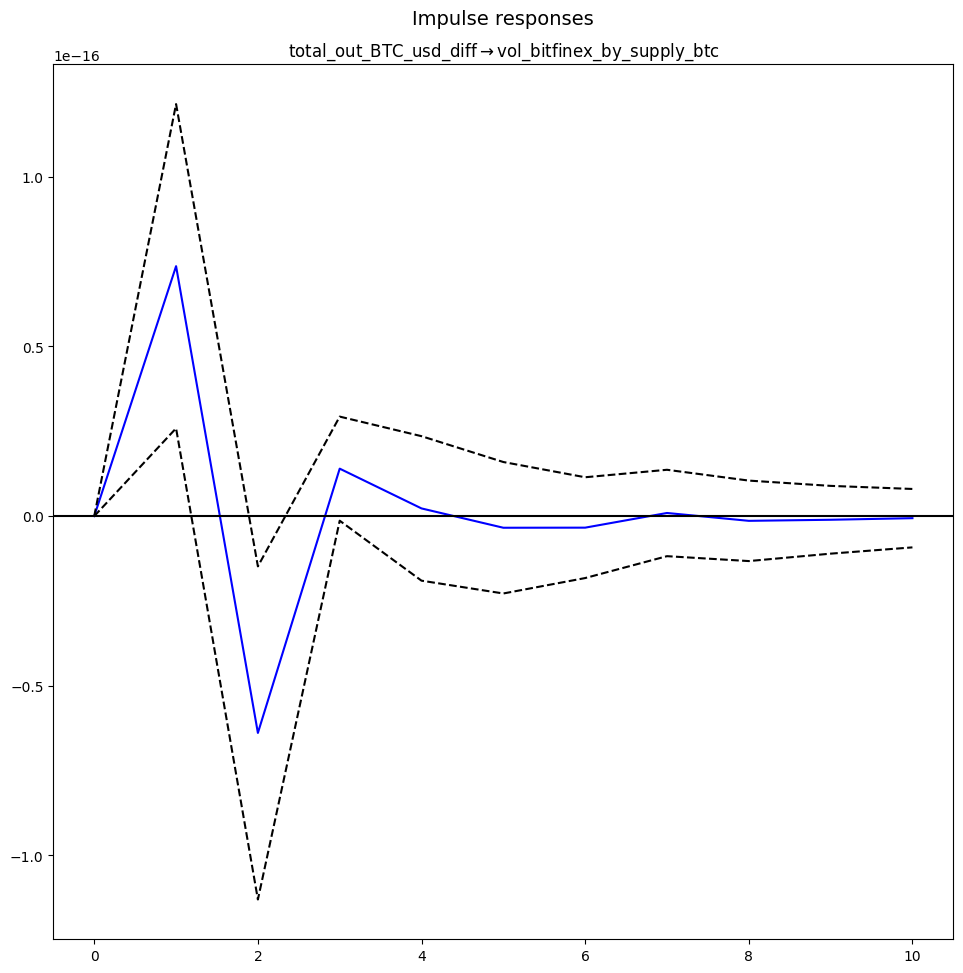

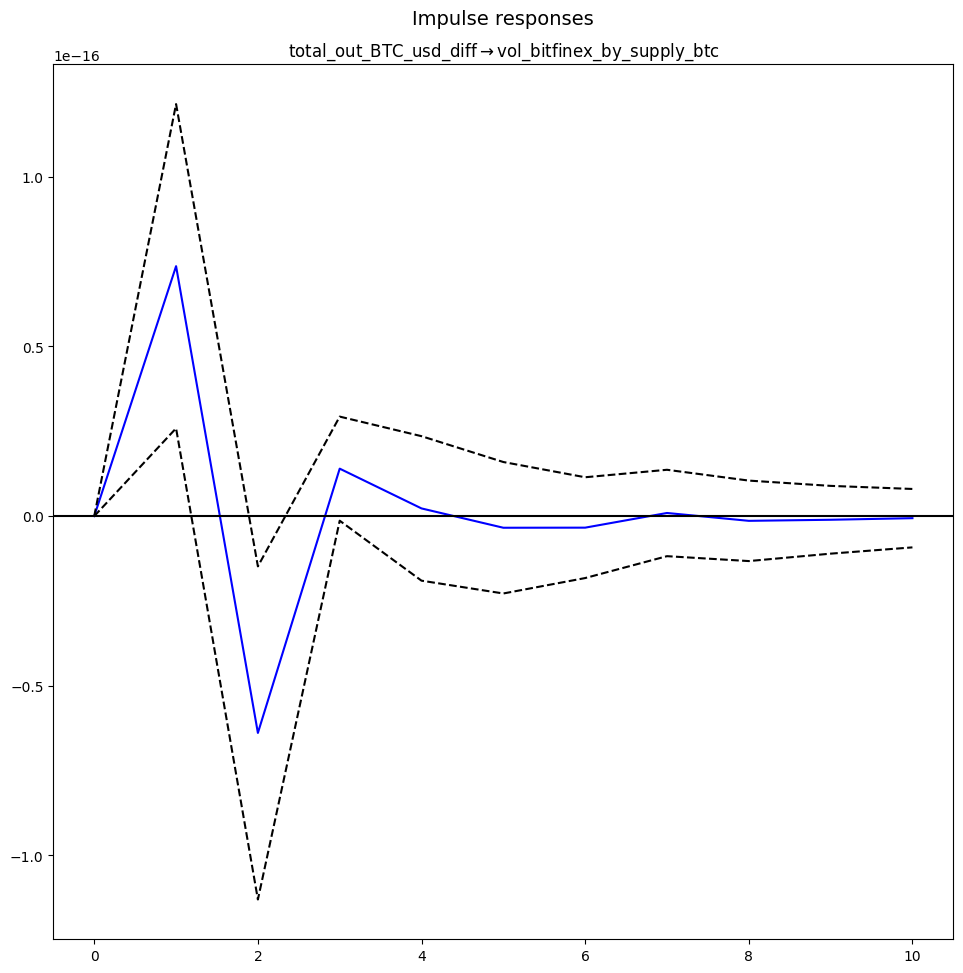

In [82]:
# Analisando o efeito de um choque nas variáveis (por exemplo, um aumento de 10 no PIB)
irf = result.irf(10)
irf.plot(impulse='total_out_BTC_usd_diff', response='vol_bitfinex_by_supply_btc')

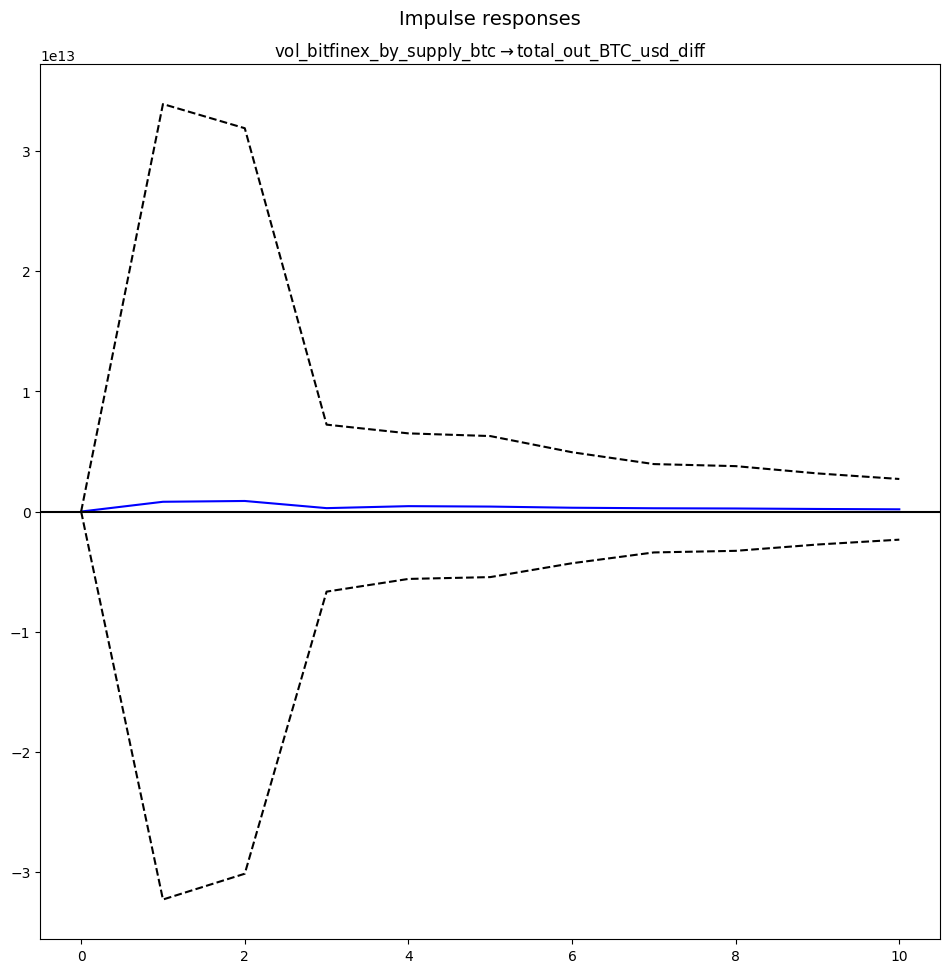

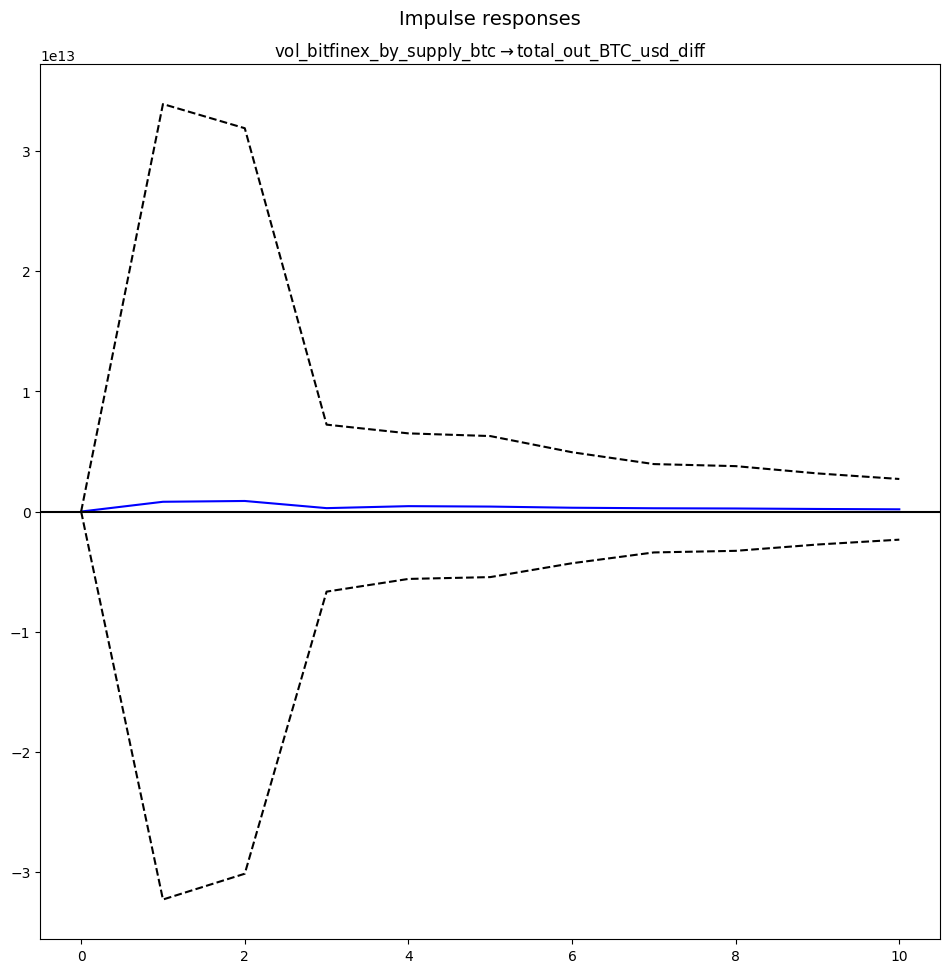

In [83]:
# Analisando o efeito de um choque nas variáveis (por exemplo, um aumento de 10 no PIB)
irf = result.irf(10)
irf.plot(impulse='vol_bitfinex_by_supply_btc', response='total_out_BTC_usd_diff')